In [31]:
# Author: Liam Collins

import numpy as np
import matplotlib
from matplotlib import colors, pyplot as plt

## Figure 1

### Generate data

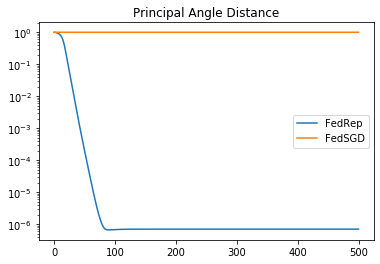

In [206]:
d = 20
k = 2
n = 100
m = 10
m_test=100
n_test=n
sigma2=0.001
T=500
r=1

Ystar = np.random.normal(size=(d,k))
Vstar, R = np.linalg.qr(Ystar)
VstarT = Vstar.T

Xstar = np.random.normal(size=(n,k))
Ustar, R = np.linalg.qr(Xstar)
for i in range(n):
    Ustar[i,:]= Ustar[i,:]/np.linalg.norm(Ustar[i,:])

Mstar = np.dot(Ustar,Vstar.T)

Xstar = np.random.normal(size=(n_test,k))
Ustar_test, R = np.linalg.qr(Xstar)
Mstar_test = np.dot(Ustar_test,Vstar.T)

I = np.eye(d)
A = np.zeros((n,m,d))
A_test = np.zeros((n_test,m_test,d))
Y = np.zeros((n,m))
Y_test = np.zeros((n_test,m_test))
for i in range(n):
    # train data
    for j in range(m):
        A[i,j,:] = np.random.normal(size=(d))/(np.sqrt(m))
        Y[i,j] = np.dot(Mstar[i,:], A[i,j,:] ) + np.random.normal(0, sigma2)
    # test data
for i in range(n_test):
    for j in range(m_test):
        A_test[i,j,:] = np.random.normal(size=(d))/(np.sqrt(m_test))
        Y_test[i,j] = np.dot(Mstar[i,:] , A_test[i,j,:] ) + np.random.normal(0, sigma2)

V_fedrep = np.random.normal(size=(d,k)) 
U_fedrep = np.random.normal(size=(n,k)) 
    
u_fedsgd = np.random.normal(size=(k,1))
V_fedsgd = np.random.normal(size=(d,k))

# alpha = 3.5/2
# beta = 0.01/2
eta_fedrep = 0.1#25
eta_fedsgd = 0.005

dist_fedrep = np.zeros(T)
dist_fedsgd = np.zeros(T)

rn = r*n
spreads = np.zeros(T)

for t in range(T):
    
    clients= np.random.choice(n,max(1,int(rn)),replace=False)
    
    V_fedrep_orth, RVorth = np.linalg.qr(V_fedrep)
    V_fedsgd_orth, RVorth = np.linalg.qr(V_fedsgd)

    dist_fedrep[t] = np.linalg.norm(np.dot((np.eye(d) - np.dot(V_fedrep_orth, V_fedrep_orth.T)), Vstar), ord=2)**2
    dist_fedsgd[t] = np.linalg.norm(np.dot((np.eye(d) - np.dot(V_fedsgd_orth, V_fedsgd_orth.T)), Vstar), ord=2)**2

    GV_fr = np.zeros((d,k)) 
    GV = np.zeros((d,k))      
    Gu = np.zeros((k,1))
    for i in clients:
        Xi = A[i,:,:]
        wi = np.dot(np.linalg.inv(np.dot(np.dot(Xi,V_fedrep).T, np.dot(Xi,V_fedrep))), np.dot(np.dot(Xi,V_fedrep).T, Y[i,:].T))
        U_fedrep[i,:] = wi.T
        Sigma_i = np.dot(Xi.T, Xi)
    
        GV_fr += np.dot(np.dot(Sigma_i, V_fedrep),np.outer(U_fedrep[i,:], U_fedrep[i,:])) - np.outer(np.dot(Xi.T, Y[i,:]), U_fedrep[i,:])# + eta_fedrep*np.outer(np.dot(Xi.T, Y[i,:]), U_fedrep[i,:])
        Gu += (np.dot(np.dot(V_fedsgd.T, Sigma_i), np.dot(V_fedsgd,u_fedsgd)) -np.expand_dims(np.dot(V_fedsgd.T, np.dot(Xi.T, Y[i,:])), axis=-1))/len(clients)
        GV += np.dot(V_fedsgd,np.outer(u_fedsgd, u_fedsgd)) - np.outer(np.dot(Xi.T, Y[i,:]), u_fedsgd)
    
    V_fedrep = V_fedrep - eta_fedrep*GV_fr
    V_fedsgd = V_fedsgd - eta_fedsgd*GV
    u_fedsgd = u_fedsgd - eta_fedsgd*Gu
    
e_local_fin = 0
e_fedrep_fin = 0
e_fedsgd_fin = 0
for i in range(n):
    Xi = A[i,:,:]
    wi = np.dot(np.linalg.inv(np.dot(Xi.T, Xi)+0.00001*np.eye(d)), np.dot(Xi.T, Y[i,:].T))
    ui = np.dot(np.linalg.inv(np.dot(np.dot(V_fedsgd.T,Xi.T), np.dot(Xi, V_fedsgd))+0.00001*np.eye(k)), np.dot(np.dot(V_fedsgd.T,Xi.T), Y[i,:].T))
    for j in range(m_test):
        # Note that we mistakenly divided these errors by m_test for the figure in the paper even though
        # the variance of the data is already 1/m_test. The code here corrects for this, and qualitatively, the results
        # are the same, because the same incorrect scaling was applied to all methods.
        e_local_fin += (Y_test[i,j] - np.dot(A_test[i,j,:], wi))**2/(2*n)
        e_fedrep_fin += (Y_test[i,j] - np.dot(A_test[i,j,:], np.dot(V_fedrep,U_fedrep[i,:].T)))**2/(2*n)
        e_fedsgd_fin += (Y_test[i,j] - np.dot(A_test[i,j,:], np.dot(V_fedsgd,ui)))**2/(2*n)

plt.figure(2)
plt.title('Principal Angle Distance')
plt.plot(dist_fedrep,label='FedRep')
plt.plot(dist_fedsgd,label='FedSGD')
plt.yscale('log')
plt.legend()

In [205]:
m5amg = e_fedrep_fin
m5fed = e_fedsgd_fin
m5loc = e_local_fin

In [207]:
m10amg = e_fedrep_fin
m10fed = e_fedsgd_fin
m10loc = e_local_fin

In [199]:
m20amg = e_fedrep_fin
m20fed = e_fedsgd_fin
m20loc = e_local_fin

### Plot Figure 1

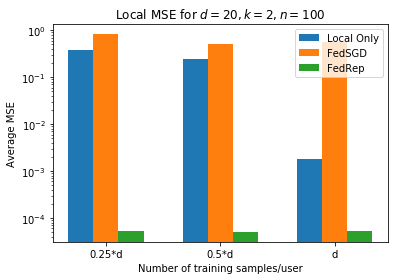

In [209]:
e_fed = [m5fed, m10fed, m20fed]
e_amg = [m5amg, m10amg, m20amg]
e_loc = [m5loc, m10loc, m20loc]

width = 0.22

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

ind = np.arange(3)
plt.figure(23)
plt.bar(ind, e_loc, width, label='Local Only')
plt.bar(ind+width, e_fed, width, label='FedSGD')
plt.bar(ind+2*width, e_amg, width,
    label='FedRep')
plt.yscale('log')
plt.ylabel('Average MSE')

plt.xticks(ind + width , ('0.25*d','0.5*d', 'd'))
plt.xlabel('Number of training samples/user')
plt.legend(loc='best')
plt.title('Local MSE for $d=20, k=2, n=100$')
plt.savefig('bar_fig1.pdf', format='pdf')

## Figure 4

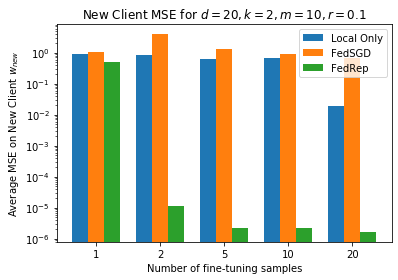

In [218]:
s = [1,2,5,10,20]
d=20

e_fed = np.zeros((len(s)))
e_amg= np.zeros((len(s)))
e= np.zeros((len(s)))

n_test=100

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Fine-tune the head based on the pre-trained representation
for i,samples in enumerate(s):
    X = np.random.normal(size=(samples,d))/np.sqrt(samples)
    gram = np.dot(X.T, X)
    
    for j in range(n_test):
        wstar = np.random.normal(size=(k))
        ustar = np.dot(Vstar, wstar)
        
        y_train = np.dot(np.dot(X, Vstar), wstar) + np.random.normal(size=(samples))*sigma2
        Xy = np.dot(X.T,y_train)
                                                                       
        wfed = np.dot(np.linalg.inv(np.dot(np.dot(V_fedsgd.T, gram), V_fedsgd) + 0.00001*np.eye(k)), np.dot(V_fedsgd.T, Xy))
        wamg = np.dot(np.linalg.inv(np.dot(np.dot(V_fedrep.T, gram), V_fedrep) + 0.00001*np.eye(k)), np.dot(V_fedrep.T, Xy))
        
        w = np.dot(np.linalg.inv(gram + 0.00001*np.eye(d)), Xy)
        
        X_test = np.random.normal(size=(50,d))/np.sqrt(50)
        y_test = np.dot( X_test, np.dot(Vstar, wstar))
        yfed = np.dot( X_test, np.dot(V_fedsgd, wfed))
        yamg = np.dot( X_test, np.dot(V_fedrep, wamg))
        y = np.dot(X_test, w)
        
        e_fed[i] += np.linalg.norm(y_test- yfed)**2/(2*n_test)
        e_amg[i] += np.linalg.norm(y_test- yamg)**2/(2*n_test)
        e[i] += np.linalg.norm(y_test- y)**2/(2*n_test)
        
width = 0.25  
ind = np.arange(len(s))
plt.figure(23)
plt.bar(ind, e, width, label='Local Only')
plt.bar(ind+width, e_fed, width, label='FedSGD')
plt.bar(ind + 2*width, e_amg, width,
    label='FedRep')
plt.yscale('log')
plt.ylabel('Average MSE on New Client $w_{new}$')

plt.xticks(ind + width , ('1','2', '5', '10', '20'))
plt.xlabel('Number of fine-tuning samples')
plt.legend(loc='best')
plt.title('New Client MSE for $d=20, k=2, m=10, r=0.1$')
plt.savefig('bar_fig4.pdf', format='pdf')


## Figure 3

In [225]:
def top_k_SVD(M):
    X, s, Y = np.linalg.svd(M)
    Mk = np.dot(np.dot(X[:,:k], np.diag(s[:k])), Y[:,:k].T)
    return Mk

ns = [10,100,1000]
ms = [5]

# tuned learning rates
lrs_amg = np.asarray([[0.4,4,60],[3,3.5,4]])
lrs_add = np.asarray([[0.12,0.75,1],[0.75,0.75,1]])
lrs_aff = np.asarray([[0.01,0.4,0.25],[0.75,0.75,1]])

T = 200
r=0.1

e_amg_means = np.zeros((T, len(ns),len(ms) ))
e_add_means = np.zeros((T, len(ns),len(ms) ))
e_aff_means = np.zeros((T, len(ns),len(ms) ))
e_amg_stddevs = np.zeros((T, len(ns),len(ms) ))
e_add_stddevs = np.zeros((T, len(ns),len(ms) ))

paWamg_means = np.zeros((T, len(ns),len(ms) ))
paWadd_means = np.zeros((T, len(ns),len(ms) ))
paWaff_means = np.zeros((T, len(ns),len(ms) ))
paWamg_stddevs = np.zeros((T, len(ns),len(ms) ))
paWadd_stddevs = np.zeros((T, len(ns),len(ms) ))

paBamg_means = np.zeros((T, len(ns),len(ms) ))
paBadd_means = np.zeros((T, len(ns),len(ms) ))
paBaff_means = np.zeros((T, len(ns),len(ms) ))
paBamg_stddevs = np.zeros((T, len(ns),len(ms) ))
paBadd_stddevs = np.zeros((T, len(ns),len(ms) ))

for ii in range(len(ns)):
    for jj in range(len(ms)):

        s= 1
        d = 10
        k = 2
        n = ns[ii]
        rn = int(r*n)
        m = ms[jj] 
        m_test=50
        sigma2 = 0.001
        alpha = lrs_amg[jj,ii]
        beta = lrs_add[jj,ii]
        betaff = lrs_aff[jj,ii]
        trials = 1
        e_amg = np.zeros((T, trials))
        e_add = np.zeros((T, trials))
        e_aff = np.zeros((T, trials))
        paB_amg = np.zeros((T, trials))
        paW_amg = np.zeros((T, trials))
        paB_add = np.zeros((T, trials))
        paW_add = np.zeros((T, trials))
        paB_aff = np.zeros((T, trials))
        paW_aff = np.zeros((T, trials))

        for tri in range(trials):

            Ystar = np.random.normal(size=(d,k))
            Vstar, R = np.linalg.qr(Ystar)
            VstarT = Vstar.T

            Xstar = np.random.normal(size=(n,k))
            Ustar, R = np.linalg.qr(Xstar)

            Mstar = np.dot(np.dot(Ustar,np.eye(k)),Vstar.T)

            I = np.eye(d)

            A = np.zeros((n,m,d))
            A_test = np.zeros((n,m_test,d))
            Y = np.zeros((n,m))
            Y_test = np.zeros((n,m_test))
            for i in range(n):
                # train data
                for j in range(m):
                    A[i,j,:] = np.random.normal(size=(d))/(np.sqrt(m))
                    Y[i,j] = np.dot(Mstar[i,:], A[i,j,:] ) + np.random.normal(0,sigma2)
                # test data
                for j in range(m_test):
                    A_test[i,j,:] = np.random.normal(size=(d))/(np.sqrt(m))
                    Y_test[i,j] = np.dot(Mstar[i,:] , A_test[i,j,:] ) + np.random.normal(0,sigma2)

            V = np.random.normal(size=(d,k))
            U = np.random.normal(size=(n,k))
            Vdd = np.random.normal(size=(d,k))
            Udd = np.random.normal(size=(n,k))

            errors = np.zeros(T)
            errors_dd = np.zeros(TT)
            errs = np.zeros(TT)
            errs2 = np.zeros(TT)
            errs3 = np.zeros(TT)
            estar=0
            errstar = np.ones(TT)
            sine = np.zeros(TT)
            sine2 = np.zeros(TT)
            sine3 = np.zeros(TT)
            sine4 = np.zeros(TT)
            sine5 = np.zeros(TT)
            sine6 = np.zeros(TT)
            sine7 = np.zeros(TT)
            sine8 = np.zeros(TT)
            sine9 = np.zeros(TT)

            Tinit = 10
            M = np.random.normal(size=(n,d))
            Mk = top_k_SVD(M)
            eta_init = 0.1
            for tau in range(Tinit):
                add = np.zeros((n,d))
                for i in range(n):
                    for j in range(m):
                        aij = np.zeros((n,d))
                        aij[i,:] = A[i,j,:]
                        add += (np.trace(np.dot(aij.T, Mk)) - Y[i,j])*aij

                M = Mk - eta_init*add
                Mk = top_k_SVD(M)

            U, s, V = np.linalg.svd(Mk)
            U = U[:,:k]
            V = V[:,:k]

            Vdd = V
            Udd = U
            
            Vff = V
            Uff = U

            Vfedsgd = V
            ufedsgd = U[0,:]
            Vfedavg = V
            ufedavg = U[0,:]

            w = np.random.normal(size=(d))

            for t in range(T):
        
                clients = np.random.choice(n, rn, replace=False)

                # compute principal angle distances and errors
                if t>=0:
                    Vorth,RVorth = np.linalg.qr(V) 
                    Vddorth,RVddorth = np.linalg.qr(Vdd)
                    Vfforth,RVddorth = np.linalg.qr(Vff)
                    Uorth,RVorth = np.linalg.qr(U)
                    Uddorth,RVddorth = np.linalg.qr(Udd) 
                    Ufforth,RVfforth = np.linalg.qr(Uff)

                    sine[t] = (np.linalg.norm(Mstar - np.dot(U,V.T)))**2/(2*n)
                    sine3[t] = (np.linalg.norm(Mstar - np.dot(Udd,Vdd.T)))**2/(2*n)
                    sine9[t] = (np.linalg.norm(Mstar - np.dot(Uff,Vff.T)))**2/(2*n)
                    sine2[t] = np.linalg.norm(np.dot(Uorth, Uorth.T) - np.dot(Ustar,Ustar.T ))**2
                    sine4[t] = np.linalg.norm(np.dot(Uddorth, Uddorth.T) - np.dot(Ustar,Ustar.T ))**2
                    sine7[t] = np.linalg.norm(np.dot(Ufforth, Ufforth.T) - np.dot(Ustar,Ustar.T ))**2
                    sine5[t] = np.linalg.norm(np.dot((np.eye(d) - np.dot(Vorth, Vorth.T)), Vstar), ord=2)**2
                    sine6[t] = np.linalg.norm(np.dot((np.eye(d) - np.dot(Vddorth, Vddorth.T)), Vstar), ord=2)**2
                    sine8[t] = np.linalg.norm(np.dot((np.eye(d) - np.dot(Vfforth, Vfforth.T)), Vstar), ord=2)**2

                # take minimization step wrt U
                for i in clients:
                    Xi = A[i,:,:] 
                    wi = np.dot(np.linalg.inv(np.dot(np.dot(Xi,V).T, np.dot(Xi,V))), np.dot(np.dot(Xi,V).T, Y[i,:].T))
                    U[i,:] = wi.T

                # grad step wrt U
                gdd = np.zeros(U.shape)
                add = np.zeros((n,d))
                gff = np.zeros(U.shape)
                aff = np.zeros((n,d))
                for i in clients:
                    # train data
                    for j in range(m):
                        uvdd = np.dot(Udd, Vdd.T)
                        uvff = np.dot(Uff, Vff.T)
                        aij = np.zeros((n,d))
                        aij[i,:] = A[i,j,:]
                        add += (np.trace(np.dot(aij.T, uvdd)) - Y[i,j])*aij
                        aff += (np.trace(np.dot(aij.T, uvff)) - Y[i,j])*aij
                gdd = np.dot(add,Vdd) 
                Udd = Udd - beta*gdd
                gff = np.dot(aff,Vff) 
                Uff = Uff - betaff*gff
                
                for iii in range(9):
                    gff = np.zeros(U.shape)
                    aff = np.zeros((n,d))
                    for i in clients:
                        # train data
                        for j in range(m):
                            uvff = np.dot(Uff, Vff.T)
                            aij = np.zeros((n,d))
                            aij[i,:] = A[i,j,:]
                            aff += (np.trace(np.dot(aij.T, uvff)) - Y[i,j])*aij
                    gff = np.dot(aff,Vff) 
                    
                    Uff = Uff - betaff*gff

                # take grad step wrt V
                a = np.zeros((d,n))
                add = np.zeros((d,n))
                aff = np.zeros((d,n))
                gw = np.zeros(d)
                gV = np.zeros((d,k))
                gu = np.zeros(k)
                for i in clients:
                    for j in range(m):
                        uv = np.dot(U, V.T)
                        uvdd = np.dot(Udd, Vdd.T)
                        uvff = np.dot(Uff, Vff.T)
                        aij = np.zeros((d,n))
                        aij[:,i] = A[i,j,:]
                        a += (np.trace(np.dot(aij, uv)) - Y[i,j] )*aij 
                        add += (np.trace(np.dot(aij, uvdd)) - Y[i,j])*aij
                        aff += (np.trace(np.dot(aij, uvff)) - Y[i,j])*aij

                g = np.dot(a,U)
                gdd = np.dot(add,Udd) 
                gff = np.dot(aff,Uff) 

                V = V - alpha*g
                Vdd = Vdd - beta*gdd
                Vff = Vff - beta*gff
                
            e_amg[:,tri] = sine
            e_add[:,tri] = sine3
            e_aff[:,tri] = sine9
            paB_amg[:,tri] = sine5
            paW_amg[:,tri] = sine2
            paB_add[:,tri] = sine6
            paW_add[:,tri] = sine4
            paB_aff[:,tri] = sine7
            paW_aff[:,tri] = sine8
    
        e_amg_means[:,ii,jj] = np.mean(e_amg,axis=1)
        e_add_means[:,ii,jj] = np.mean(e_add,axis=1)
        e_aff_means[:,ii,jj] = np.mean(e_aff,axis=1)
        e_amg_stddevs[:,ii,jj] = np.std(e_amg,axis=1)
        e_add_stddevs[:,ii,jj] = np.std(e_add,axis=1)
        
        paWamg_means[:,ii,jj] = np.mean(e_amg,axis=1)
        paWadd_means[:,ii,jj] = np.mean(e_add,axis=1)
        paWaff_means[:,ii,jj] = np.mean(e_aff,axis=1)
        paWamg_stddevs[:,ii,jj] = np.std(e_amg,axis=1)
        paWadd_stddevs[:,ii,jj] = np.std(e_add,axis=1)
        
        paBamg_means[:,ii,jj] = np.mean(e_amg,axis=1)
        paBadd_means[:,ii,jj] = np.mean(e_add,axis=1)
        paBaff_means[:,ii,jj] = np.mean(e_aff,axis=1)
        paBamg_stddevs[:,ii,jj] = np.std(e_amg,axis=1)
        paBadd_stddevs[:,ii,jj] = np.std(e_add,axis=1)

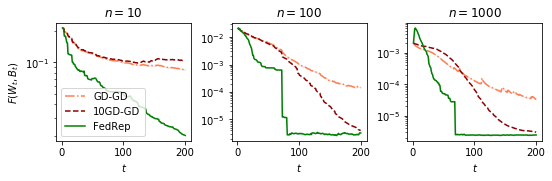

In [226]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

T=200
iters = np.linspace(1,T,T)
        
plt.figure(12,figsize=[15,5])
for ii in range(len(ns)):
    for jj in range(len(ms)):
        plt.subplot(2,5,1+ii+5*jj)
        plt.yscale("log")
        
        plt.plot(iters,paBadd_means[:,ii,jj], '-.', c='coral', label='GD-GD')
        plt.plot(iters,paBaff_means[:,ii,jj], '--', c='darkred', label='10GD-GD')
        plt.plot(iters,paBamg_means[:,ii,jj], c='g', label='FedRep')

        plt.fill_between(iters, (paBamg_means[:,ii,jj]-paBamg_stddevs[:,ii,jj]), (paBamg_means[:,ii,jj]+paBamg_stddevs[:,ii,jj]), color='darkblue', alpha=.1)
        plt.fill_between(iters, (paBadd_means[:,ii,jj]-paBadd_stddevs[:,ii,jj]), (paBadd_means[:,ii,jj]+paBadd_stddevs[:,ii,jj]), color='firebrick', alpha=.1)
        if ii == 0 and jj == 0:
            plt.legend()
        if ii == 0:
            xx=0
            plt.ylabel("$F(W_t, B_t)$")
        if jj == 0:
            plt.xlabel("$t$")
        plt.title('$n={}$'.format(ns[ii]))
plt.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(wspace = 0.3)
plt.savefig('synth3.pdf', format='pdf')